# Use stain normalization to test the filters for feature extraction

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.filters import threshold_isodata, threshold_minimum, threshold_li, threshold_mean
from skimage.morphology import disk, binary_closing
from skimage.segmentation import clear_border

from __future__ import print_function

import cv2

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

def StainNormalization(image):
    ############### INPUT RGB IMAGE #######################
    global img
    
    img = cv2.imread(image, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # create stain to color map
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    #print('stain_color_map:', stain_color_map, sep='\n')

    # specify stains of input image
    stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains
    
    I_0 = 255

    w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(img, I_0)

    # Perform color deconvolution
    deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(img, w_est, I_0)
    
    global H, cl_img, dst, thresh1, inverted, opening
    
    H = deconv_result.Stains[:, :, 1]
    
    clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize=(8,8))
    cl_img = clahe.apply(H)
    
    dst = cv2.fastNlMeansDenoising(cl_img, None, 20, 7, 21)
    
    thresh = threshold_li(dst)
    binary = dst > thresh
    
    inverted = ~binary
    inverted = inverted.astype(np.uint8)
    inverted = inverted*255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
    opening = cv2.morphologyEx(inverted, cv2.MORPH_OPEN, kernel)
    
    #Remove edge touching grains
    opening = clear_border(opening) 
        
    # sure background area
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    sure_bg = cv2.dilate(opening,kernel,iterations=2)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    #plt.imsave('unknown.png', unknown,cmap='gray')
    
    global markers
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+10

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    #Let us color boundaries in yellow. 
    #Remember that watershed assigns boundaries a value of -1
    
    #image = cv2.imread("Abnormal variation in nuclear shape/1.png")

    markers = cv2.watershed(img,markers)

    #Let us color boundaries in yellow. 
    #Remember that watershed assigns boundaries a value of -1 
    
    img[markers == -1] = [255,255,0]
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig = plt.imshow(img)
    plt.axis('off')
    #plt.show()    

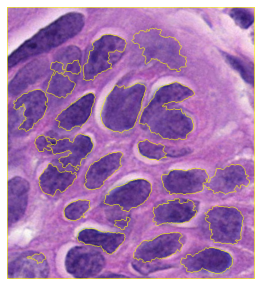

In [20]:
StainNormalization("Abnormal Variation in Nuclear Shape/1.png") 

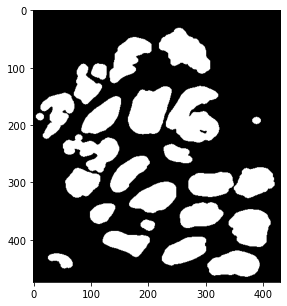

In [21]:
plt.imshow(opening)

# RegionProps

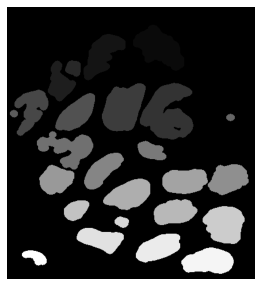

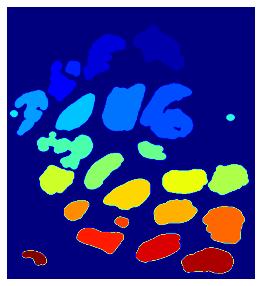

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.morphology import area_closing, area_opening

label_im = label(opening)
regions = regionprops(label_im)

plt.imshow(label_im)
plt.axis("off")
plt.show()

plt.imshow(label_im,cmap='jet')
plt.axis("off")
plt.show()

In [23]:
properties = ['area','convex_area','bbox_area',
              'major_axis_length', 'minor_axis_length', 
              'perimeter', 'equivalent_diameter',
              'mean_intensity', 'solidity', 'eccentricity']
pd.DataFrame(regionprops_table(label_im, dst, 
                               properties=properties)).head(10)

,area,convex_area,bbox_area,major_axis_length,minor_axis_length,perimeter,equivalent_diameter,mean_intensity,solidity,eccentricity
0,4123,4681,7120,98.725838,55.966199,287.220346,72.453893,71.043172,0.880795,0.823797
1,3124,3614,5913,97.179110,44.830266,269.178716,63.068220,57.240397,0.864416,0.887236
2,1904,2274,3528,67.441215,42.086960,202.693434,49.236654,77.886555,0.837291,0.781381
3,594,616,783,28.818507,26.852664,91.597980,27.500987,75.843434,0.964286,0.363010
4,5872,7103,9207,104.617071,87.153172,449.730014,86.466540,64.990123,0.826693,0.553170
5,4558,4794,6384,94.181991,63.815437,277.036580,76.180220,58.542782,0.950772,0.735453
6,2589,3249,4779,83.871213,49.537778,299.605122,57.414434,59.999614,0.796861,0.806934
7,2677,2752,4554,86.118674,40.258159,217.622366,58.382037,45.010459,0.972747,0.884007
8,143,147,196,14.242205,12.790447,42.041631,13.493452,74.300699,0.972789,0.439860
9,147,151,195,15.147349,12.353082,42.627417,13.680870,98.795918,0.973510,0.578718


In [24]:
features =  pd.DataFrame(regionprops_table(label_im, dst,properties=properties))

In [25]:
print(features.head(5))

   area  convex_area  bbox_area  major_axis_length  minor_axis_length  \
0  4123         4681       7120          98.725838          55.966199   
1  3124         3614       5913          97.179110          44.830266   
2  1904         2274       3528          67.441215          42.086960   
3   594          616        783          28.818507          26.852664   
4  5872         7103       9207         104.617071          87.153172   

    perimeter  equivalent_diameter  mean_intensity  solidity  eccentricity  
0  287.220346            72.453893       71.043172  0.880795      0.823797  
1  269.178716            63.068220       57.240397  0.864416      0.887236  
2  202.693434            49.236654       77.886555  0.837291      0.781381  
3   91.597980            27.500987       75.843434  0.964286      0.363010  
4  449.730014            86.466540       64.990123  0.826693      0.553170  


<b> For the illustration of identified nuclei via plotly </b>

In [26]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology
from skimage.io import imread

img = imread("Abnormal Variation in Nuclear Shape/1.png", as_gray = True)

# Binary image, post-process the binary mask and compute labels

labels = measure.label(opening)

fig = px.imshow(img, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean']

In [ ]:
# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)

## Function to get properties

In [27]:
def get_properties():
    properties = ['area', 'perimeter', 'eccentricity', 'mean_intensity']
    dataframe = pd.DataFrame(columns=properties)
    labeled = label(opening)
    regions = regionprops(labeled)
    data = pd.DataFrame(regionprops_table(labeled, dst,
                                          properties=properties))
    data = data[(data.index != 0) & (data.area > 100)]
    dataframe = pd.concat([dataframe, data])
    return dataframe

In [28]:
A = get_properties()
print("The shape of the dataframe is: ", A.shape)
A.head()

The shape of the dataframe is:  (24, 4)


,area,perimeter,eccentricity,mean_intensity
1,3124,269.178716,0.887236,57.240397
2,1904,202.693434,0.781381,77.886555
3,594,91.59798,0.36301,75.843434
4,5872,449.730014,0.55317,64.990123
5,4558,277.03658,0.735453,58.542782


In [34]:
A['roundness circularity'] = 4*np.pi*(A['area']/A['perimeter']**2)

#final_df = df[df.drop('type', axis=1).columns].astype(float)

#final_df = final_df.replace(np.inf, 0)

A.head()

,area,perimeter,eccentricity,mean_intensity,roundness circularity
1,3124,269.178716,0.887236,57.240397,0.541801
2,1904,202.693434,0.781381,77.886555,0.582368
3,594,91.59798,0.36301,75.843434,0.889661
4,5872,449.730014,0.55317,64.990123,0.364831
5,4558,277.03658,0.735453,58.542782,0.746294


## To loop the operation over files

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log



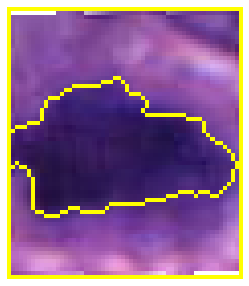

In [36]:
import os

path = "D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia"
dfs = []

for count, file in enumerate(os.listdir(path)):
    if file.endswith(".png"):
        output_file = f"Masked {str(count)}.png"
        f = os.path.join(path, file)
        StainNormalization(f)
        df = get_properties()
        df['roundness circularity'] = 4*np.pi*(df['area']/df['perimeter']**2)
        dfs.append(df)
        
df_final = pd.concat(dfs, ignore_index=True)

In [37]:
dfs

[  area  perimeter eccentricity mean_intensity roundness circularity
 1  121  38.627417     0.452998      84.239669               1.01907,
    area   perimeter eccentricity mean_intensity roundness circularity
 1   383   72.526912     0.706644      63.663185              0.914977
 2   579   95.355339     0.849932      70.789292                0.8002
 3   161   44.870058     0.532966      82.354037              1.004899
 4   121   38.627417     0.452998      88.107438               1.01907
 5   347   73.254834     0.829719      65.680115              0.812581
 6  1399  242.285317     0.815733      78.162259              0.299484
 7   270   60.284271     0.712967      90.362963               0.93361,
 Empty DataFrame
 Columns: [area, perimeter, eccentricity, mean_intensity, roundness circularity]
 Index: [],
    area   perimeter eccentricity mean_intensity roundness circularity
 1  2982  224.066017     0.750333      59.725352              0.746389,
     area   perimeter eccentricity mean

In [38]:
df_final = pd.concat(dfs, ignore_index=True)

In [39]:
df_final

,area,perimeter,eccentricity,mean_intensity,roundness circularity
0,121,38.627417,0.452998,84.239669,1.01907
1,383,72.526912,0.706644,63.663185,0.914977
2,579,95.355339,0.849932,70.789292,0.8002
3,161,44.870058,0.532966,82.354037,1.004899
4,121,38.627417,0.452998,88.107438,1.01907
...,...,...,...,...,...
1722,2690,229.480231,0.885998,66.866543,0.641906
1723,1288,147.681241,0.794292,65.173137,0.742122
1724,4424,357.03658,0.95353,43.621383,0.436114
1725,1208,142.610173,0.789486,43.28394,0.746407


In [69]:
 df_final.to_csv('Hyperchromasia.csv', index=False)

## Final Operation (Loop over all images)

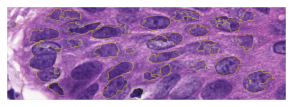

In [12]:
import os

path = "D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia"
dfs = []

for count, file in enumerate(os.listdir(path)):
    if file.endswith(".png"):
        #output_file = f"Masked {str(count)}.png"
        #f = os.path.join(path, file)
        StainNormalization(f)
        df = get_properties()
        df['roundness circularity'] = 4*np.pi*(df['area']/df['perimeter']**2)
        dfs.append(df)
        
df_final = pd.concat(dfs, ignore_index=True)
df_final.to_csv('Hyperchromasia.csv', index=False)

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)
c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)
c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)
c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)
c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)
c:\users\teoh\histomicstk\histomicstk\preproc

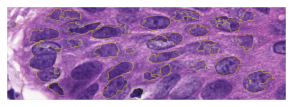

In [11]:
import os

path = "D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Final//AbnormalVariationInNuclearShape"
dfs = []

for count, file in enumerate(os.listdir(path)):
    if file.endswith(".png"):
        #output_file = f"Masked {str(count)}.png"
        f = os.path.join(path, file)
        StainNormalization(f)
        df = get_properties()
        df['roundness circularity'] = 4*np.pi*(df['area']/df['perimeter']**2)
        dfs.append(df)
        
df_final = pd.concat(dfs, ignore_index=True)
df_final.to_csv('Abnormal Shape.csv', index=False)